In [45]:
# Default imports 
import numpy as np
import scipy as sp

import math
import random
%matplotlib inline 
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [46]:
import sys
import time
from sklearn.decomposition import PCA
import pylab as pl

In [47]:
import operator
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import mixture

In [48]:
df= pd.read_csv("data/covtype_data.csv", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [49]:
#check size
df.shape

(581012, 55)

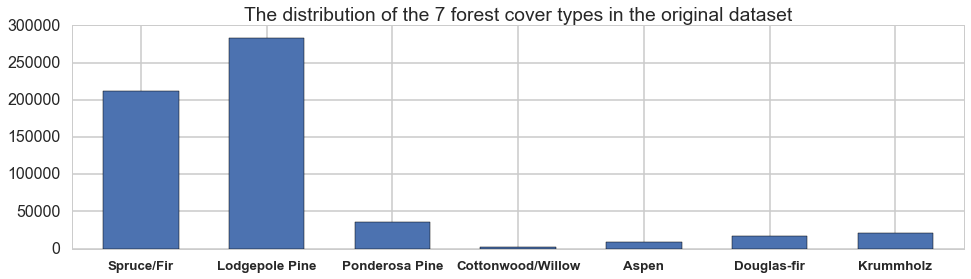

In [50]:
#draw a distribution graph
plt.figure(figsize=(16,4))
ax=df.groupby(54).count()[0].plot(kind="bar",width=.6)
labels = ['Spruce/Fir','Lodgepole Pine','Ponderosa Pine','Cottonwood/Willow','Aspen','Douglas-fir', 'Krummholz']
# plt.xticks(range(7),labels, ha='left')
ax.set_xticklabels(labels, rotation=0, size = 'x-small', weight='bold')
plt.xlabel('')
plt.title("The distribution of the 7 forest cover types in the original dataset")
plt.show()

In [45]:
#Use the accuracy recorded to draw a k selection graph
accuracy = [0.26005605822187255, 0.26005605822187255, 0.19345003933910307,  0.18667633752950433, 0.26123623131392604, 0.26691581431943351,
0.2744148308418568, 0.25826121164437449, 0.26161732887490163,
0.28475363886703381, 0.27127999606608971, 0.27982395751376871,
0.28319236821400473, 0.27988542486231316,  0.27988542486231316,
0.28035257671125097, 0.34586447678992921, 0.27581628638867034,
0.21219758064516128, 0.21225904799370574, 0.28180320613690008,
0.21894669551534224, 0.26991542092840282, 0.22719561369000787]
k = range(7,31)

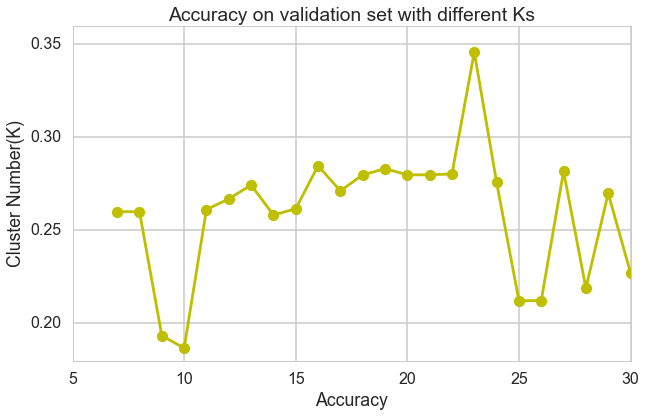

In [48]:
fig, (ax) = plt.subplots(1, 1, figsize=(10,6))
ax.plot(k, accuracy, '-yo')
ax.set_title("Accuracy on validation set with different Ks")
ax.set_xlabel("Accuracy")
ax.set_ylabel('Cluster Number(K)')
plt.show()

In [56]:
def predict(centers, cluster_dic, x_test):
    y_pred = []
    
    for i in range(x_test.shape[0]):
        x = x_test.iloc[i,:].values   #iterate rows
        dist={}
        #find the closest center
        for center in cluster_dic.keys(): #iterate 7 clusters we picked 
            dist[center] = distance.euclidean(centers[center], x)   #dist[0] means the distance of this data with 0_th cluster
        sorted_dist= sorted(dist.items(), key=operator.itemgetter(1))#sort by distance, ascending order
        y_pred.append(cluster_dic[sorted_dist[0][0]])#find the lable, append label
        
    return y_pred

In [57]:
def assign(table_percent, t, cluster_dic, cluster_index, i):
    if cluster_index in cluster_dic:
        j = cluster_dic[cluster_index]
        
#         print("i,j", i, j)
#         print("cluster_index", cluster_index)
        ivalue = table_percent.loc[cluster_index,'label_'+str(i)]
        jvalue = table_percent.loc[cluster_index,'label_'+str(j)]
        if ivalue > jvalue:
            cluster_dic[cluster_index] = i
            #reassign j
            t[j]=t[j][1:]
            assign(table_percent, t, cluster_dic, t[j][0], j)
    
        else:
            cluster_dic[cluster_index] = j
            #reassign i
            t[i]=t[i][1:]
            assign(table_percent, t, cluster_dic,t[i][0], i)
            
    else:
        cluster_dic[cluster_index] = i

In [58]:
def selectK(start, end):
    accuracy = {}
    for K in range(start, end+1):
        print("K:", K)
        kmeans = KMeans(n_clusters=K, random_state=0).fit(x_train)
        table = pd.DataFrame(np.zeros((K,7)),columns=['label_1', 'label_2', 'label_3', 'label_4','label_5','label_6','label_7'])

        pred = pd.DataFrame(data = kmeans.labels_, columns=['cluster'])
        for k in range(K):
            for i in range(1,8):  
                c = y_train.iloc[pred[pred['cluster']==k].index]
                table.loc[k,'label_'+str(i)] = c[c==i].shape[0] 
          
        table_percent = table/table.sum(axis=0) #build the percentage table
        print(table_percent)
        
        t = {}  #t[i] is array of i_th category that in the descending order of percentage
        
        #pick the cluster with the highest ratio of a label as the category center
        #build a dictionary
        cluster_dic={}  #key: cluster    #value: true category

        for i in range(1,8): 
            t[i] = table_percent['label_'+str(i)].sort_values(ascending = False).index
            assign(table_percent, t, cluster_dic, t[i][0], i)#assign the highest cluster to i_th label
        
        
        print("cluster_dic", cluster_dic)
        y_pred = predict(kmeans.cluster_centers_, cluster_dic,x_val) #predict
        accuracy[K] = np.array(y_val==y_pred).sum()/float(len(y_pred)) #check accuracy
        print("accuracy", accuracy[K])
        
    return accuracy

## Save the picked cluster centers

In [51]:
df_train_full = pd.read_csv("data/train_full.csv")
df_train_full.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
0,0.781493,0.077778,0.060606,0.021475,0.000000,0.697906,0.858268,0.913386,0.590551,0.374878,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.764126,0.955556,0.106061,0.021475,0.000000,0.270620,0.811024,0.901575,0.637795,0.209118,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.861068,0.825000,0.090909,0.215462,0.089850,0.465927,0.795276,0.937008,0.688976,0.231842,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.822188,0.325000,0.045455,0.432355,-0.003328,0.556133,0.885827,0.929134,0.574803,0.544681,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.796527,0.000000,0.075758,0.202577,0.009983,0.727273,0.838583,0.909449,0.614173,0.363725,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [52]:
#Use best K to train the whole train dataset
X_train = df_train_full.iloc[:, :-1]
Y_train = df_train_full.iloc[: ,-1]
print(X_train.shape)
print(Y_train.shape)

(406704, 54)
(406704,)


In [53]:
#Now train the whole train dataset, test on the test dataset
kmeans = KMeans(n_clusters=23, random_state=0).fit(X_train)

In [54]:
table = pd.DataFrame(np.zeros((23,7)),columns=['label_1', 'label_2', 'label_3', 'label_4','label_5','label_6','label_7'])
pred = pd.DataFrame(data = kmeans.labels_, columns=['cluster'])
for k in range(23):
    for i in range(1,8):  
        c = Y_train.iloc[pred[pred['cluster']==k].index]
        table.loc[k,'label_'+str(i)] = c[c==i].shape[0] 

table_percent = table/table.sum(axis=0) #build the percentage table
print(table_percent)        

     label_1   label_2   label_3   label_4   label_5   label_6   label_7
0   0.026523  0.009505  0.000000  0.000000  0.000000  0.000000  0.000000
1   0.056471  0.083980  0.000000  0.000000  0.014447  0.000000  0.004667
2   0.075738  0.087071  0.000160  0.000000  0.055681  0.031178  0.029744
3   0.004451  0.031950  0.037080  0.000000  0.027690  0.191017  0.000000
4   0.012705  0.096485  0.000000  0.000000  0.000000  0.000000  0.000000
5   0.000000  0.006722  0.286810  0.080645  0.000000  0.324367  0.000000
6   0.081288  0.037714  0.000000  0.000000  0.026787  0.000000  0.015394
7   0.090749  0.099183  0.003077  0.000000  0.045749  0.011681  0.040332
8   0.036146  0.071217  0.000000  0.000000  0.223025  0.000000  0.009961
9   0.053565  0.046064  0.000000  0.000000  0.032054  0.003537  0.010867
10  0.044346  0.022989  0.000000  0.000000  0.000000  0.008144  0.004806
11  0.060592  0.026277  0.000000  0.000000  0.045899  0.002057  0.018877
12  0.071820  0.015324  0.000000  0.000000  0.00000

In [59]:
t = {}  #t[i] is array of i_th category that in the descending order of percentage

#pick the cluster with the highest ratio of a label as the category center
#build a dictionary
cluster_dic={}  #key: cluster    #value: true category

for i in range(1,8): 
    t[i] = table_percent['label_'+str(i)].sort_values(ascending = False).index
    assign(table_percent, t, cluster_dic, t[i][0], i)#assign the highest cluster to i_th label

print("cluster_dic", cluster_dic)

('cluster_dic', {5: 6, 8: 5, 18: 1, 19: 3, 20: 4, 21: 7, 22: 2})


In [74]:
picked_centers=[]

In [75]:
#save 7 picked centers
for center in cluster_dic.keys(): #iterate 7 clusters we picked 
    picked_centers.append(kmeans.cluster_centers_[center])
picked_centers

[array([  5.95985608e-01,   6.29292348e-01,   3.68954835e-01,
          1.29602011e-01,   1.10724598e-01,   1.04819792e-01,
          6.62080204e-01,   7.89589738e-01,   6.42082614e-01,
          1.06551888e-01,   1.10855769e-13,   1.38777878e-15,
          3.27515792e-14,   1.00000000e+00,  -5.07406617e-16,
         -1.63064007e-16,   1.72258041e-15,  -1.38777878e-16,
          5.46437895e-17,  -3.49373308e-15,   4.13081028e-17,
         -9.56266316e-17,   2.95119831e-16,   1.00000000e+00,
         -2.99413272e-15,  -5.77315973e-15,  -8.97545926e-15,
          1.98625838e-16,  -7.34377565e-19,   6.58327559e-16,
         -1.16920362e-15,  -6.62230687e-16,   1.05644660e-15,
         -3.42781359e-15,   5.20417043e-18,  -3.05311332e-16,
          1.48769885e-14,  -4.83640905e-15,  -3.43692089e-17,
         -4.94396191e-16,  -5.16947596e-16,  -3.85975973e-17,
          2.77555756e-16,  -1.46410661e-15,   4.10088630e-15,
          1.11022302e-15,  -1.56402669e-14,   3.56051993e-16,
        

In [76]:
c = pd.DataFrame(picked_centers,columns = X_train.columns)
c

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
0,0.595986,0.629292,0.368955,0.129602,0.110725,0.104820,0.662080,0.789590,0.642083,0.106552,1.108558e-13,1.387779e-15,3.275158e-14,1.000000e+00,-5.074066e-16,-1.630640e-16,1.722580e-15,-1.387779e-16,5.464379e-17,-3.493733e-15,4.130810e-17,-9.562663e-17,2.951198e-16,1.000000e+00,-2.994133e-15,-5.773160e-15,-8.975459e-15,1.986258e-16,-7.343776e-19,6.583276e-16,-1.169204e-15,-6.622307e-16,1.056447e-15,-3.427814e-15,5.204170e-18,-3.053113e-16,1.487699e-14,-4.836409e-15,-3.436921e-17,-4.943962e-16,-5.169476e-16,-3.859760e-17,2.775558e-16,-1.464107e-15,4.100886e-15,1.110223e-15,-1.564027e-14,3.560520e-16,5.316927e-16,4.220257e-17,8.906721e-17,-3.299444e-15,5.846018e-15,2.386980e-15
1,0.758645,0.393988,0.250460,0.160605,0.072155,0.401055,0.881603,0.868916,0.485957,0.319812,1.000000e+00,1.394718e-15,4.135581e-14,-2.187139e-14,1.776357e-15,1.762479e-15,3.162401e-15,1.069977e-14,-9.913945e-16,-4.767020e-15,6.014612e-17,-1.391031e-16,3.835907e-16,-2.643719e-14,7.289308e-15,-1.650763e-14,-1.088712e-14,3.831570e-16,1.913447e-18,-1.530026e-15,-1.667937e-15,-8.855763e-16,-4.666406e-16,-4.159867e-15,-4.839878e-16,-1.249695e-14,5.170864e-14,1.287859e-14,-3.040103e-16,-5.351622e-16,-6.316562e-16,-1.823628e-16,-6.034062e-14,1.000000e+00,-1.291328e-14,-3.798351e-14,-1.845746e-14,3.773024e-16,5.980459e-16,4.672911e-17,2.014448e-16,1.425943e-15,8.139323e-15,4.111295e-16
2,0.804867,0.393604,0.188026,0.176230,0.069219,0.449776,0.839866,0.874576,0.555737,0.372119,1.000000e+00,1.401657e-15,-8.254508e-14,-2.522982e-14,1.715642e-15,-2.402592e-15,3.571796e-15,1.377717e-14,-1.288032e-15,-5.129577e-15,2.758198e-03,5.018388e-03,3.041679e-02,-3.102379e-14,5.828671e-15,-1.110223e-15,-1.143183e-14,4.356324e-16,4.020018e-18,5.730922e-02,4.588344e-16,4.857493e-02,7.244101e-02,1.833819e-01,-2.818926e-18,-1.595946e-14,6.217249e-14,7.753601e-02,-3.804465e-16,-5.464379e-16,-6.643991e-16,3.243933e-16,4.857226e-15,1.604966e-14,-1.774275e-14,-4.907186e-14,-1.924849e-14,3.829402e-16,1.739197e-02,4.803016e-17,5.784554e-03,2.005440e-01,1.825774e-01,1.162657e-01
3,0.685497,0.477036,0.315924,0.149300,0.097043,0.212656,0.850033,0.933042,0.567883,0.186491,6.272760e-14,1.360023e-15,1.000000e+00,6.272760e-15,1.856154e-16,-1.474515e-15,-4.701101e-16,1.000000e+00,2.255141e-17,-1.543904e-15,1.252254e-17,-2.916504e-17,1.595946e-16,5.426215e-15,-3.268219e-15,5.974388e-15,-6.047246e-15,-5.984796e-17,-5.996993e-19,-1.977585e-16,-4.085274e-16,-3.209238e-16,8.916479e-16,-2.307182e-15,7.762888e-17,1.020017e-14,-5.537237e-15,-2.990663e-15,1.160096e-16,-4.328135e-16,-3.410900e-16,1.697861e-16,3.430589e-14,-7.306655e-15,1.630640e-15,9.839352e-15,-1.133815e-14,3.243933e-16,4.293441e-16,3.523657e-17,-5.215012e-17,-2.664535e-15,2.341877e-15,-1.925543e-15
4,0.578882,0.426180,0.316996,0.120081,0.093087,0.097342,0.845911,0.839522,0.479953,0.102977,7.627232e-14,1.366962e-15,-5.345724e-14,1.000000e+00,2.401877e-01,1.699279e-01,1.955601e-01,1.008124e-01,1.307930e-01,-2.092077e-15,2.059984e-17,-4.781332e-17,1.977585e-16,5.537237e-15,4.828928e-02,6.099288e-15,-6.869505e-15,2.711981e-02,3.432887e-04,2.322920e-02,6.373727e-02,-4.167673e-16,9.384854e-16,-2.622902e-15,1.298874e-16,1.192102e-14,-5.731526e-15,-3.511080e-15,1.233822e-16,-4.501607e-16,-3.905296e-16,2.252972e-16,3.630429e-14,-9.138523e-15,3.455569e-15,1.068590e-14,-1.255940e-14,3.335006e-16,4.579670e-16,3.718813e-17,-3.453184e-17,-2.844947e-15,3.327200e-15,-1.594211e-15
5,0.856407,0.520864,0.234831,0.336800,0.163177,0.405380,0.811332,0.884221,0.590272,0.239766,1.068590e-13,1.380840e-15,1.000000e+00,-8.590351e-15,-5.568462e-16,-6.036838e-16,1.538700e-15,-1.516148e-15,1.877838e-16,-3.330669e-15,3.892286e-17,-9.009720e-17,2.838441e-16,-8.222589e-15,-4.180684e-15,-3.518019e-15,-8.732598e-15,1.752071e-16,-7.233661e-19,5.872039e-16,5.002501e-04,-6.340414e-16,1.167250e-03,-3.334139e-15,6.765422e-17,1.

In [77]:
c.to_csv("data/selected_centers.csv", index=False)

In [78]:
#read again for check
c = pd.read_csv("data/selected_centers.csv")
c

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
0,0.595986,0.629292,0.368955,0.129602,0.110725,0.104820,0.662080,0.789590,0.642083,0.106552,1.108558e-13,1.387779e-15,3.275158e-14,1.000000e+00,-5.074066e-16,-1.630640e-16,1.722580e-15,-1.387779e-16,5.464379e-17,-3.493733e-15,4.130810e-17,-9.562663e-17,2.951198e-16,1.000000e+00,-2.994133e-15,-5.773160e-15,-8.975459e-15,1.986258e-16,-7.343776e-19,6.583276e-16,-1.169204e-15,-6.622307e-16,1.056447e-15,-3.427814e-15,5.204170e-18,-3.053113e-16,1.487699e-14,-4.836409e-15,-3.436921e-17,-4.943962e-16,-5.169476e-16,-3.859760e-17,2.775558e-16,-1.464107e-15,4.100886e-15,1.110223e-15,-1.564027e-14,3.560520e-16,5.316927e-16,4.220257e-17,8.906721e-17,-3.299444e-15,5.846018e-15,2.386980e-15
1,0.758645,0.393988,0.250460,0.160605,0.072155,0.401055,0.881603,0.868916,0.485957,0.319812,1.000000e+00,1.394718e-15,4.135581e-14,-2.187139e-14,1.776357e-15,1.762479e-15,3.162401e-15,1.069977e-14,-9.913945e-16,-4.767020e-15,6.014612e-17,-1.391031e-16,3.835907e-16,-2.643719e-14,7.289308e-15,-1.650763e-14,-1.088712e-14,3.831570e-16,1.913447e-18,-1.530026e-15,-1.667937e-15,-8.855763e-16,-4.666406e-16,-4.159867e-15,-4.839878e-16,-1.249695e-14,5.170864e-14,1.287859e-14,-3.040103e-16,-5.351622e-16,-6.316562e-16,-1.823628e-16,-6.034062e-14,1.000000e+00,-1.291328e-14,-3.798351e-14,-1.845746e-14,3.773024e-16,5.980459e-16,4.672911e-17,2.014448e-16,1.425943e-15,8.139323e-15,4.111295e-16
2,0.804867,0.393604,0.188026,0.176230,0.069219,0.449776,0.839866,0.874576,0.555737,0.372119,1.000000e+00,1.401657e-15,-8.254508e-14,-2.522982e-14,1.715642e-15,-2.402592e-15,3.571796e-15,1.377717e-14,-1.288032e-15,-5.129577e-15,2.758198e-03,5.018388e-03,3.041679e-02,-3.102379e-14,5.828671e-15,-1.110223e-15,-1.143183e-14,4.356324e-16,4.020018e-18,5.730922e-02,4.588344e-16,4.857493e-02,7.244101e-02,1.833819e-01,-2.818926e-18,-1.595946e-14,6.217249e-14,7.753601e-02,-3.804465e-16,-5.464379e-16,-6.643991e-16,3.243933e-16,4.857226e-15,1.604966e-14,-1.774275e-14,-4.907186e-14,-1.924849e-14,3.829402e-16,1.739197e-02,4.803016e-17,5.784554e-03,2.005440e-01,1.825774e-01,1.162657e-01
3,0.685497,0.477036,0.315924,0.149300,0.097043,0.212656,0.850033,0.933042,0.567883,0.186491,6.272760e-14,1.360023e-15,1.000000e+00,6.272760e-15,1.856154e-16,-1.474515e-15,-4.701101e-16,1.000000e+00,2.255141e-17,-1.543904e-15,1.252254e-17,-2.916504e-17,1.595946e-16,5.426215e-15,-3.268219e-15,5.974388e-15,-6.047246e-15,-5.984796e-17,-5.996993e-19,-1.977585e-16,-4.085274e-16,-3.209238e-16,8.916479e-16,-2.307182e-15,7.762888e-17,1.020017e-14,-5.537237e-15,-2.990663e-15,1.160096e-16,-4.328135e-16,-3.410900e-16,1.697861e-16,3.430589e-14,-7.306655e-15,1.630640e-15,9.839352e-15,-1.133815e-14,3.243933e-16,4.293441e-16,3.523657e-17,-5.215012e-17,-2.664535e-15,2.341877e-15,-1.925543e-15
4,0.578882,0.426180,0.316996,0.120081,0.093087,0.097342,0.845911,0.839522,0.479953,0.102977,7.627232e-14,1.366962e-15,-5.345724e-14,1.000000e+00,2.401877e-01,1.699279e-01,1.955601e-01,1.008124e-01,1.307930e-01,-2.092077e-15,2.059984e-17,-4.781332e-17,1.977585e-16,5.537237e-15,4.828928e-02,6.099288e-15,-6.869505e-15,2.711981e-02,3.432887e-04,2.322920e-02,6.373727e-02,-4.167673e-16,9.384854e-16,-2.622902e-15,1.298874e-16,1.192102e-14,-5.731526e-15,-3.511080e-15,1.233822e-16,-4.501607e-16,-3.905296e-16,2.252972e-16,3.630429e-14,-9.138523e-15,3.455569e-15,1.068590e-14,-1.255940e-14,3.335006e-16,4.579670e-16,3.718813e-17,-3.453184e-17,-2.844947e-15,3.327200e-15,-1.594211e-15
5,0.856407,0.520864,0.234831,0.336800,0.163177,0.405380,0.811332,0.884221,0.590272,0.239766,1.068590e-13,1.380840e-15,1.000000e+00,-8.590351e-15,-5.568462e-16,-6.036838e-16,1.538700e-15,-1.516148e-15,1.877838e-16,-3.330669e-15,3.892286e-17,-9.009720e-17,2.838441e-16,-8.222589e-15,-4.180684e-15,-3.518019e-15,-8.732598e-15,1.752071e-16,-7.233661e-19,5.872039e-16,5.002501e-04,-6.340414e-16,1.167250e-03,-3.334139e-15,6.765422e-17,1.

## Predict on testing data and save the prediciton

In [18]:
df_test = pd.read_csv("data/test.csv")
df_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
0,0.820373,0.191667,0.242424,0.282749,0.069884,0.433750,0.925197,0.811024,0.385827,0.445839,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.839295,0.744444,0.106061,0.125268,0.023295,0.821976,0.795276,0.956693,0.704724,0.186393,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.817781,0.158333,0.227273,0.292054,0.053245,0.441197,0.901575,0.818898,0.429134,0.437892,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.815448,0.163889,0.257576,0.292054,0.169717,0.444850,0.905512,0.799213,0.397638,0.433849,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.813634,0.147222,0.212121,0.279885,0.158070,0.448644,0.893701,0.818898,0.437008,0.429946,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [32]:
x_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[: ,-1]
print(x_test.shape)
print(y_test.shape)

(174308, 54)
(174308,)


In [36]:

y_pred = predict(kmeans.cluster_centers_, cluster_dic,x_test) #predict
accuracy_final= np.array(y_test==y_pred).sum()/float(len(y_pred)) #check accuracy
print("accuracy", accuracy_final)

('cluster_dic', {5: 6, 8: 5, 18: 1, 19: 3, 20: 4, 21: 7, 22: 2})
('accuracy', 0.28933267549395325)


In [38]:
#save the prediction for the test file
pred = pd.DataFrame(data = y_pred, columns=['label'])
pred.to_csv("data/pred.csv", index=False, header=True)

## Choose 10% out of the testing dataset and visualize

In [22]:
#choose 10% sample from the test dataset
df_test_sample = pd.DataFrame(columns = df_test.columns)

for i in range(1,8):
    subset = df_test[df_test['54']==i]
    rows = random.sample(subset.index, int(subset.shape[0]*0.1))
    
    df_test_sample = df_test_sample.append(df_test.ix[rows],ignore_index=True)

In [23]:
df_test_sample.shape

(17428, 55)

In [24]:
x_test_sample = df_test_sample.iloc[:, :-1]
y_test_sample = df_test_sample.iloc[: ,-1]

In [25]:
#visualize in 2D dimension (first and second component in PCA)
pca = PCA(n_components=2).fit(x_test_sample)
pca_2d = pca.transform(x_test_sample)

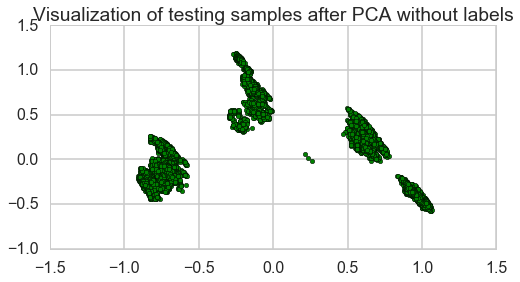

In [30]:
pl.figure(figsize=(8,4))  
pl.scatter(pca_2d[:,0],pca_2d[:,1],c='green')
pl.title('Visualization of testing samples after PCA without labels')
pl.show()

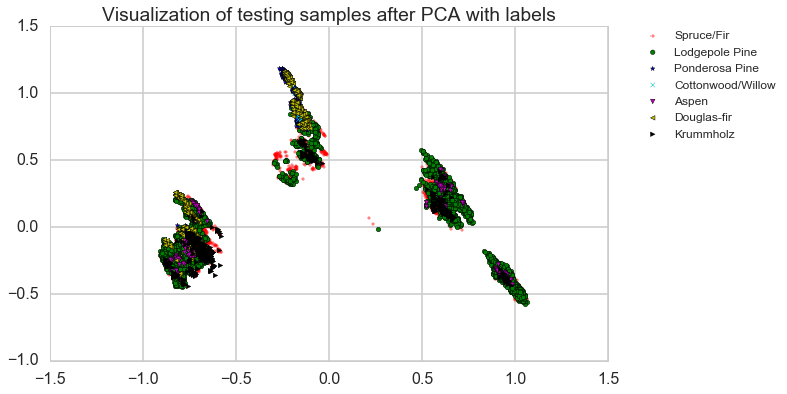

In [40]:
n = pca_2d.shape[0]
pl.figure(figsize=(10,6))  
for i in range(n):
    
    if y_test_sample[i] == 1:
        c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r', marker='+')
    elif y_test_sample[i] == 2:
        c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g', marker='o')
    elif y_test_sample[i] == 3:
        c3 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='b', marker='*')
    elif y_test_sample[i] == 4:
        c4 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='c', marker='x')
    elif y_test_sample[i] == 5:
        c5 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='m', marker='v')
    elif y_test_sample[i] == 6:
        c6 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='y', marker='<')
    elif y_test_sample[i] == 7:
        c7 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='k', marker='>')

#     sys.stdout.write("\r{0} percent ".format(i/float(n)*100))
#     sys.stdout.flush()
pl.legend([c1,c2,c3,c4,c5,c6,c7],['Spruce/Fir','Lodgepole Pine','Ponderosa Pine','Cottonwood/Willow','Aspen','Douglas-fir', 'Krummholz'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size':12})
pl.title('Visualization of testing samples after PCA with labels')
pl.show()

In [80]:
#do prediction 
y_pred_sample = predict(kmeans.cluster_centers_, cluster_dic,x_test_sample) #predict
accuracy_final= np.array(y_test_sample==y_pred_sample).sum()/float(len(y_pred_sample)) #check accuracy
print("accuracy", accuracy_final)

('accuracy', 0.29159972458113381)


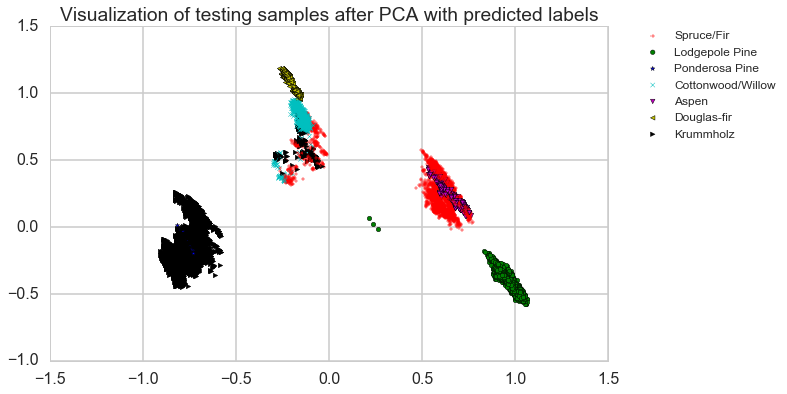

In [81]:
n = pca_2d.shape[0]
pl.figure(figsize=(10,6))  
for i in range(n):
    
    if y_pred_sample[i] == 1:
        c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r', marker='+')
    elif y_pred_sample[i] == 2:
        c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g', marker='o')
    elif y_pred_sample[i] == 3:
        c3 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='b', marker='*')
    elif y_pred_sample[i] == 4:
        c4 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='c', marker='x')
    elif y_pred_sample[i] == 5:
        c5 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='m', marker='v')
    elif y_pred_sample[i] == 6:
        c6 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='y', marker='<')
    elif y_pred_sample[i] == 7:
        c7 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='k', marker='>')

#     sys.stdout.write("\r{0} percent ".format(i/float(n)*100))
#     sys.stdout.flush()
pl.legend([c1,c2,c3,c4,c5,c6,c7],['Spruce/Fir','Lodgepole Pine','Ponderosa Pine','Cottonwood/Willow','Aspen','Douglas-fir', 'Krummholz'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size':12})
pl.title('Visualization of testing samples after PCA with predicted labels')
pl.show()